## Iceburg or Boat?

In [1]:
import numpy as np
import pandas as pd
import os
# import keras

from skimage.util.montage import montage2d
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#path = r"/Users/nicapotato/Google Drive/Learning/Jupyter/Data/Icebergs"
path = r"D:\My Computer\DATA\Icebergs"
os.chdir(path)

In [4]:
def load_and_format(in_path):
    out_df = pd.read_json(in_path)
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
    out_images = np.stack(out_images).squeeze()
    return out_df, out_images

train_df, train_images = load_and_format('train.json')
print('training', train_df.shape, 'loaded', train_images.shape)
#test_df, test_images = load_and_format('test.json')
#print('testing', test_df.shape, 'loaded', test_images.shape)
train_df.sample(3)

training (1604, 5) loaded (1604, 75, 75, 2)


,band_1,band_2,id,inc_angle,is_iceberg
638,"[-21.006029, -21.730309, -24.882505, -28.13708...","[-28.136974, -25.443041, -26.358227, -26.35826...",20936ccc,45.2859,1
870,"[-24.43387, -26.120329, -26.120369, -23.467899...","[-31.541624, -28.619102, -26.764065, -27.10477...",8dbefcbd,44.6139,1
1069,"[-17.634449, -17.843834, -17.843834, -19.34320...","[-27.49276, -23.864433, -23.864433, -26.292953...",0b2e007c,32.785,1


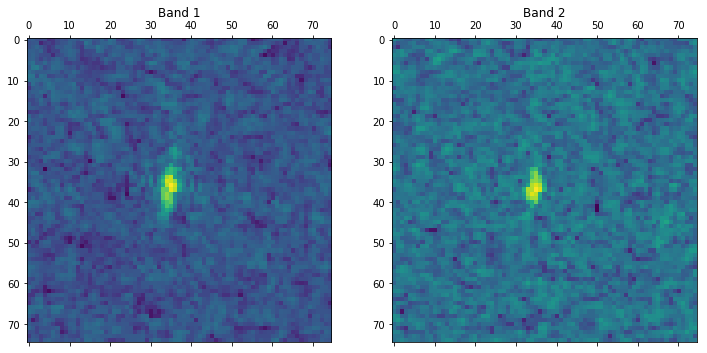

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize= (12,6))
# Set image base
ax1.matshow(train_images[0,:,:,0]) #image 0 band 1 (0)
ax1.set_title('Band 1')
ax2.matshow(train_images[0,:,:,1]) #image0, band 2 (1)
ax2.set_title('Band 2')

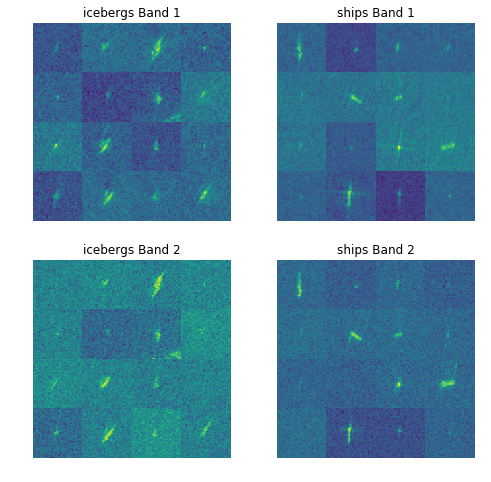

In [6]:
fig, (ax1s, ax2s) = plt.subplots(2,2, figsize = (8,8))
obj_list = dict(ships = train_df.query('is_iceberg==0').sample(16).index,
     icebergs = train_df.query('is_iceberg==1').sample(16).index)
for ax1, ax2, (obj_type, idx_list) in zip(ax1s, ax2s, obj_list.items()):
    ax1.imshow(montage2d(train_images[idx_list,:,:,0]))
    ax1.set_title('%s Band 1' % obj_type)
    ax1.axis('off')
    ax2.imshow(montage2d(train_images[idx_list,:,:,1]))
    ax2.set_title('%s Band 2' % obj_type)
    ax2.axis('off')

In [7]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = \
train_test_split(train_images, train_df.is_iceberg,
                 test_size=0.20, random_state=1)

num_classes = len(np.unique(Y_train)) # number of classes
img_size = 75

print("Number of training samples: %d"%X_train.shape[0])
#print( "Number of test samples: %d"%test_features.shape[0])
print("Image rows: %d"%X_train.shape[1])
print("Image columns: %d"%X_train.shape[2])
print("Number of classes: %d"%num_classes)

for i in (X_train, X_valid, Y_train, Y_valid):
    print("shape {}".format(i.shape))

Number of training samples: 1283
Image rows: 75
Image columns: 75
Number of classes: 2
shape (1283, 75, 75, 2)
shape (321, 75, 75, 2)
shape (1283,)
shape (321,)


In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

#tensorboard --logdir=models:"D:\My Computer\DATA\Icebergs\logs\"

In [12]:
model=Sequential()
model.add(Conv2D(filters= 32, kernel_size=5, activation='relu',
                input_shape=(img_size, img_size, 2)))
model.add(MaxPooling2D(pool_size=5))
model.add(Conv2D(filters= 64, kernel_size=5, activation='relu'))
model.add(MaxPooling2D(pool_size=5))
model.add(Dropout(0.5))
model.add(Conv2D(filters= 128, kernel_size=5, activation='relu'))
model.add(MaxPooling2D(pool_size=5))
model.add(Dropout(0.5))
model.add(Conv2D(filters= 64, kernel_size=5, activation='relu'))
model.add(MaxPooling2D(pool_size=5))
model.add(Conv2D(filters= 32, kernel_size=5, activation='relu'))
model.add(MaxPooling2D(pool_size=5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy',
          metrics=['accuracy'])

model.summary()

ValueError: Negative dimension size caused by subtracting 5 from 2 for 'conv2d_8/convolution' (op: 'Conv2D') with input shapes: [?,2,2,64], [5,5,64,128].

In [ ]:
classifier.fit(X_train, y_train,
       validation_data=(X_test, y_test),
       batch_size = 32, epochs = 1, verbose=0, callbacks=[
              keras.callbacks.TensorBoard(log_dir="./logs/{}".format(datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H_%M_%S')),
                    histogram_freq=0, write_graph=False, write_images=False),
              keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=.005, patience=20,
                    verbose=0, mode='auto')])

In [ ]:
start = time.time()
model_info = model.fit(X_train, y_train, validation_data = (X_test, y_test), 
                   batch_size=128, nb_epoch=200,
                   verbose=0)
end = time.time()

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
print(confusion_matrix(y_test, y_pred))